## Imported Libraries

In [5]:
# Standard libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Handeling .wav files

import librosa
from librosa import feature

# Machine Learning

from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold

from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from functools import reduce

# data vizualisation

import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

## Merging the .csv files into one DataFrame

#### Function merge_pd

In [6]:
def merge_pd(machine):
    
    # Opening the .csv files
    
    df_6dB=pd.read_csv(f'Librosa_features_{machine}_6dB.csv')
    df_0dB=pd.read_csv(f'Librosa_features_{machine}_0dB.csv')
    df_min6dB=pd.read_csv(f'Librosa_features_{machine}_-6dB.csv')
    
    # Dropping the 'Unnamed: 0' column
    
    df_6dB.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
    df_0dB.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
    df_min6dB.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
    
    # Add the number of dB to each column name for each .csv file

    df_6dB.columns = [str(col) + '_6dB' for col in df_6dB.columns]
    df_0dB.columns = [str(col) + '_0dB' for col in df_0dB.columns]
    df_min6dB.columns = [str(col) + '_-6dB' for col in df_min6dB.columns]
    
    # Merging the .csv files into one DataFrame
    
    data_frames = [df_6dB, df_0dB, df_min6dB]
    df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True,how='outer'), data_frames)
    
    df_merged.head()
    
    return df_merged

#### Merging

In [7]:
valve = merge_pd('valve')

#### Dropping doubled columns

In [8]:
valve.drop(columns=['normal(0)/abnormal(1)_6dB','normal(0)/abnormal(1)_0dB'],axis=1,inplace=True)
valve.rename(columns={'normal(0)/abnormal(1)_-6dB': 'normal(0)/abnormal(1)'}, inplace=True)

## Machine Learning

#### Creating a pipeline for the different used models

In [9]:
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', SVC())])

#### Seperate validation, train and test data

In [10]:
# 20% of the overal data will seperated for later validation of the model

X_model, X_valid = train_test_split(valve,test_size=0.2,random_state = 42)

# 64% of the overal data (80% of X_model, y_model) will be used to create a training set for the model
# 16% of the overal data (20% of X_model, y_model) will be used to create a testing set for the model

X_train, X_test, y_train, y_test = train_test_split(X_model.drop(columns=['normal(0)/abnormal(1)'], axis=1),
                                                   X_model['normal(0)/abnormal(1)'],
                                                   test_size = 0.2,
                                                   random_state = 10)

In [11]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state=0, n_jobs=-1))
sel.fit(X_train,y_train)
sel.get_support()

array([False, False,  True, False,  True,  True, False,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False,  True])

In [12]:
X_train.columns

Index(['melspectrogram_6dB', 'melspectrogram_min_6dB',
       'melspectrogram_max_6dB', 'melspectrogram_sum_6dB',
       'melspectrogram_corr_6dB', 'melspectrogram_std_6dB', 'mfcc_6dB',
       'rms_6dB', 'spectral_centroid_6dB', 'spectral_bandwidth_6dB',
       'spectral_contrast_6dB', 'spectral_flatness _6dB',
       'spectral_rolloff_6dB', 'zero_crossing_rate_6dB', 'mean harm_6dB',
       'mean perc_6dB', 'max harm_6dB', 'max perc_6dB', 'min harm_6dB',
       'min perc_6dB', 'melspectrogram_0dB', 'melspectrogram_min_0dB',
       'melspectrogram_max_0dB', 'melspectrogram_sum_0dB',
       'melspectrogram_corr_0dB', 'melspectrogram_std_0dB', 'mfcc_0dB',
       'rms_0dB', 'spectral_centroid_0dB', 'spectral_bandwidth_0dB',
       'spectral_contrast_0dB', 'spectral_flatness _0dB',
       'spectral_rolloff_0dB', 'zero_crossing_rate_0dB', 'mean harm_0dB',
       'mean perc_0dB', 'max harm_0dB', 'max perc_0dB', 'min harm_0dB',
       'min perc_0dB', 'melspectrogram_-6dB', 'melspectrogram_min_

In [13]:
features = X_train.columns[sel.get_support()]

In [14]:
features

Index(['melspectrogram_max_6dB', 'melspectrogram_corr_6dB',
       'melspectrogram_std_6dB', 'rms_6dB', 'max perc_6dB', 'min perc_6dB',
       'melspectrogram_max_0dB', 'melspectrogram_corr_0dB', 'max perc_0dB',
       'min perc_0dB', 'melspectrogram_corr_-6dB', 'max perc_-6dB',
       'min perc_-6dB'],
      dtype='object')

In [15]:
sel.estimator_.feature_importances_

array([0.01375857, 0.        , 0.04930379, 0.01399179, 0.05124762,
       0.02430885, 0.01015612, 0.01785723, 0.00509756, 0.00931428,
       0.00620242, 0.00618926, 0.00501763, 0.00725821, 0.00428565,
       0.00435373, 0.00968271, 0.11746528, 0.01079997, 0.05952922,
       0.00894914, 0.        , 0.01890827, 0.00889168, 0.03956169,
       0.00736196, 0.00636694, 0.01101687, 0.00530833, 0.00508087,
       0.00854824, 0.00712747, 0.00565478, 0.00836467, 0.00475609,
       0.00492252, 0.00649767, 0.11847989, 0.00652377, 0.06198706,
       0.00519534, 0.        , 0.00730632, 0.00489157, 0.02963776,
       0.00440174, 0.00594519, 0.00652346, 0.00595728, 0.00549807,
       0.00607169, 0.00723945, 0.0047308 , 0.0046828 , 0.00412113,
       0.00567219, 0.00715542, 0.0631993 , 0.00576853, 0.04587416])

In [17]:
X_train_rfc = sel.transform(X_train)
X_test_rfc = sel.transform(X_test)

In [19]:
clf = RandomForestClassifier(n_estimators = 100, random_state=0, n_jobs=-1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print('confusion matrix', clf)
print(confusion_matrix(y_test, y_pred))
print('classification report')
print(classification_report(y_test, y_pred))
print('accuracy score')
print(accuracy_score(y_test, y_pred))

confusion matrix RandomForestClassifier(n_jobs=-1, random_state=0)
[[589   2]
 [ 28  49]]
classification report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       591
           1       0.96      0.64      0.77        77

    accuracy                           0.96       668
   macro avg       0.96      0.82      0.87       668
weighted avg       0.96      0.96      0.95       668

accuracy score
0.9550898203592815


In [20]:
clf = RandomForestClassifier(n_estimators = 100, random_state=0, n_jobs=-1)
clf.fit(X_train_rfc,y_train)
y_pred = clf.predict(X_test_rfc)

print('confusion matrix', clf)
print(confusion_matrix(y_test, y_pred))
print('classification report')
print(classification_report(y_test, y_pred))
print('accuracy score')
print(accuracy_score(y_test, y_pred))

confusion matrix RandomForestClassifier(n_jobs=-1, random_state=0)
[[589   2]
 [ 16  61]]
classification report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       591
           1       0.97      0.79      0.87        77

    accuracy                           0.97       668
   macro avg       0.97      0.89      0.93       668
weighted avg       0.97      0.97      0.97       668

accuracy score
0.9730538922155688


In [38]:
from sklearn.feature_selection import RFE
sel = RFE(RandomForestClassifier(n_estimators = 100, random_state=0, n_jobs=-1), n_features_to_select = 30)
sel.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
    n_features_to_select=30)

In [39]:
features = X_train.columns[sel.get_support()]

In [40]:
len(features)

30

In [41]:
X_train_rfe = sel.transform(X_train)
X_test_rfe = sel.transform(X_test)

In [42]:
clf = RandomForestClassifier(n_estimators = 100, random_state=0, n_jobs=-1)
clf.fit(X_train_rfe,y_train)
y_pred = clf.predict(X_test_rfe)

print('confusion matrix', clf)
print(confusion_matrix(y_test, y_pred))
print('classification report')
print(classification_report(y_test, y_pred))
print('accuracy score')
print(accuracy_score(y_test, y_pred))

confusion matrix RandomForestClassifier(n_jobs=-1, random_state=0)
[[588   3]
 [ 22  55]]
classification report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       591
           1       0.95      0.71      0.81        77

    accuracy                           0.96       668
   macro avg       0.96      0.85      0.90       668
weighted avg       0.96      0.96      0.96       668

accuracy score
0.9625748502994012


In [25]:
len(features)

13

In [44]:
sel = RFE(GradientBoostingClassifier(n_estimators = 100, random_state=0), n_features_to_select = index)
sel.fit(X_train, y_train)
features = X_train.columns[sel.get_support()]

In [45]:
X_train_rfe = sel.transform(X_train)
X_test_rfe = sel.transform(X_test)

In [ ]:
for index in range(1,31):
    sel = RFE(GradientBoostingClassifier(n_estimators = 100, random_state=0), n_features_to_select = index)
    sel.fit(X_train, y_train)
    features = X_train.columns[sel.get_support()]
    X_train_rfe = sel.transform(X_train)
    X_test_rfe = sel.transform(X_test)
    print('Selected Feature', index)

    clf = RandomForestClassifier(n_estimators = 100, random_state=0, n_jobs=-1)
    clf.fit(X_train_rfe,y_train)
    y_pred = clf.predict(X_test_rfe)

    print('confusion matrix', clf)
    print(confusion_matrix(y_test, y_pred))
    print('classification report')
    print(classification_report(y_test, y_pred))
    print('accuracy score')
    print(accuracy_score(y_test, y_pred))



Selected Feature 1
confusion matrix RandomForestClassifier(n_jobs=-1, random_state=0)
[[554  37]
 [ 39  38]]
classification report
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       591
           1       0.51      0.49      0.50        77

    accuracy                           0.89       668
   macro avg       0.72      0.72      0.72       668
weighted avg       0.88      0.89      0.89       668

accuracy score
0.8862275449101796
Selected Feature 2
confusion matrix RandomForestClassifier(n_jobs=-1, random_state=0)
[[577  14]
 [ 29  48]]
classification report
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       591
           1       0.77      0.62      0.69        77

    accuracy                           0.94       668
   macro avg       0.86      0.80      0.83       668
weighted avg       0.93      0.94      0.93       668

accuracy score
0.9356287425149701
Selected Feature

Selected Feature 18
confusion matrix RandomForestClassifier(n_jobs=-1, random_state=0)
[[587   4]
 [ 15  62]]
classification report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       591
           1       0.94      0.81      0.87        77

    accuracy                           0.97       668
   macro avg       0.96      0.90      0.93       668
weighted avg       0.97      0.97      0.97       668

accuracy score
0.9715568862275449
Selected Feature 19
confusion matrix RandomForestClassifier(n_jobs=-1, random_state=0)
[[586   5]
 [ 16  61]]
classification report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       591
           1       0.92      0.79      0.85        77

    accuracy                           0.97       668
   macro avg       0.95      0.89      0.92       668
weighted avg       0.97      0.97      0.97       668

accuracy score
0.968562874251497
Selected Featur

In [ ]:
# Selected columns of best performing number of features

sel = RFE(GradientBoostingClassifier(n_estimators = 100, random_state=0), n_features_to_select = 6)
sel.fit(X_train, y_train)
features = X_train.columns[sel.get_support()]
X_train_rfe = sel.transform(X_train)
X_test_rfe = sel.transform(X_test)
print('Selected Feature', 6)

clf = RandomForestClassifier(n_estimators = 100, random_state=0, n_jobs=-1)
clf.fit(X_train_rfe,y_train)
y_pred = clf.predict(X_test_rfe)

print('confusion matrix', clf)
print(confusion_matrix(y_test, y_pred))
print('classification report')
print(classification_report(y_test, y_pred))
print('accuracy score')
print(accuracy_score(y_test, y_pred))

print (features)

In [ ]:
# Selected columns




#### Training and testing each classification model

In [8]:
# Empty lists of y_pred (predicted y values) and clfs (classifiers)

y_pred = []
clfs = []

# Adding the different classifiers

clfs.append(DecisionTreeClassifier(max_features = 30))
clfs.append(RandomForestClassifier())

# Training and testing each classifier with cross validation by showing the confusion matrix,
# a classification report and the accuracy score

for classifier in clfs:
    
    # Predictions based on the classifier
    classifier.fit(X_train, y_train)
    y_pred= classifier.predict(X_test)
    
    # KFold
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv)
    
    # Gradient Boosting
    booster = GradientBoostingClassifier()
    booster.fit(X_train, y_train)
    y_boost = booster.predict(X_test)
    
    booster2 = XGBClassifier()
    booster2.fit(X_train, y_train)
    y_boost2 = booster2.predict(X_test)
    
    booster3 = LGBMClassifier()
    booster3.fit(X_train, y_train)
    y_boost3 = booster3.predict(X_test)
    
    booster4 = CatBoostClassifier(verbose=0, n_estimators=100)
    booster4.fit(X_train, y_train)
    y_boost4 = booster4.predict(X_test)
    
    # Printing results
    
    print('confusion matrix', classifier)
    print(confusion_matrix(y_test, y_pred))
    print('classification report')
    print(classification_report(y_test, y_pred))
    print('accuracy score')
    print(accuracy_score(y_test, y_pred))
    print("----------------------------------------------")
    print('confusion matrix', booster)
    print(confusion_matrix(y_test, y_boost))
    print('classification report')
    print(classification_report(y_test, y_boost))
    print('accuracy score')
    print(accuracy_score(y_test, y_boost))
    print("----------------------------------------------")
    print('confusion matrix', booster2)
    print(confusion_matrix(y_test, y_boost2))
    print('classification report')
    print(classification_report(y_test, y_boost2))
    print('accuracy score')
    print(accuracy_score(y_test, y_boost2))
    print("----------------------------------------------")
    print('confusion matrix', booster3)
    print(confusion_matrix(y_test, y_boost3))
    print('classification report')
    print(classification_report(y_test, y_boost3))
    print('accuracy score')
    print(accuracy_score(y_test, y_boost3))
    print("----------------------------------------------")
    print('confusion matrix', booster4)
    print(confusion_matrix(y_test, y_boost4))
    print('classification report')
    print(classification_report(y_test, y_boost4))
    print('accuracy score')
    print(accuracy_score(y_test, y_boost4))
    
    x_columns=list(X_train.columns)
    
    # Checking the column importance for each model in order of importance

    importance = classifier.feature_importances_
    importance_boost = classifier.feature_importances_
    
    # Summarize and show the feature importance for each feature
    
    features =[]
    features_booster =[]
    
    for i,v in enumerate(importance):
            features.append([v*100, x_columns[i]])
    features.sort(reverse=True)
    print("----------------------------------------------")
    for feature in features:
        if feature[0] > 2.0:
            print(feature[1], " : ",feature[0],"%")
            
        else:
            continue
            
    for i,v in enumerate(importance_boost):
            features_booster.append([v*100, x_columns[i]])
    features_booster.sort(reverse=True)
    print("----------------------------------------------")
    for feature in features_booster:
        if feature[0] > 2.0:
            print(feature[1], " : ",feature[0],"%")
            
        else:
            continue
    print("----------------------------------------------")
    print("----------------------------------------------")

C:\Users\vervo\anaconda3\envs\Codit\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:10:17] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix DecisionTreeClassifier(max_features=30)
[[567  24]
 [ 12  65]]
classification report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       591
           1       0.73      0.84      0.78        77

    accuracy                           0.95       668
   macro avg       0.85      0.90      0.88       668
weighted avg       0.95      0.95      0.95       668

accuracy score
0.9461077844311377
----------------------------------------------
confusion matrix GradientBoostingClassifier()
[[584   7]
 [ 23  54]]
classification report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       591
           1       0.89      0.70     

C:\Users\vervo\anaconda3\envs\Codit\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:10:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix RandomForestClassifier()
[[590   1]
 [ 27  50]]
classification report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       591
           1       0.98      0.65      0.78        77

    accuracy                           0.96       668
   macro avg       0.97      0.82      0.88       668
weighted avg       0.96      0.96      0.95       668

accuracy score
0.9580838323353293
----------------------------------------------
confusion matrix GradientBoostingClassifier()
[[584   7]
 [ 23  54]]
classification report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       591
           1       0.89      0.70      0.78        77

#### Extra information

In [11]:
# Gradient Boosting
"https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/"

# RFE
"https://www.youtube.com/watch?v=pcZ4YlvhSKU"

'https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/'

## Validation of the model

In [49]:
for classifier in clfs:
    classifier.fit(X_train, y_train)
    y_pred= classifier.predict(X_valid)
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    print('confusion matrix', classifier)
    print(confusion_matrix(y_valid, y_pred))
    print('classification report')
    print(classification_report(y_valid, y_pred))
    print('accuracy score')
    print(accuracy_score(y_valid, y_pred))
    
    x_columns=list(X_train.columns)
    
    # Checking the column importance for each model in order of importance

    importance = classifier.feature_importances_
    
    # Summarize and show the feature importance for each feature
    
    features =[]
    
    for i,v in enumerate(importance):
            features.append([v*100, x_columns[i]])
    features.sort(reverse=True)

    for feature in features:
        print(feature[1], " : ",feature[0],"%")  

ValueError: Number of features of the model must match the input. Model n_features is 60 and input n_features is 61 

### DecisionTreeClassifier

confusion matrix DecisionTreeClassifier(max_features=60)

[[713  29]
 [ 18  74]]
 
classification report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       742
           1       0.72      0.80      0.76        92

Feature: 2,	 Name: melspectrogram_max_6dB, 	 Score: 16.00351
Feature: 5,	 Name: melspectrogram_std_6dB, 	 Score: 4.59963
Feature: 17,	 Name: max perc_6dB, 	 Score: 24.62465
Feature: 37,	 Name: max perc_0dB, 	 Score: 20.86794
Feature: 57,	 Name: max perc_-6dB, 	 Score: 8.51790

accuracy score
0.9436450839328537

### DecisionTreeClassifier reduced

confusion matrix DecisionTreeClassifier(max_depth=35)

confusion matrix DecisionTreeClassifier(max_depth=35)
[[716  26]
 [ 19  73]]
classification report
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       742
           1       0.74      0.79      0.76        92


confusion matrix DecisionTreeClassifier(max_features=13)

[[718  24]
 [ 20  72]]
 
classification report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       742
           1       0.75      0.78      0.77        92

    accuracy                           0.95       834
   macro avg       0.86      0.88      0.87       834
weighted avg       0.95      0.95      0.95       834

accuracy score
0.947242206235012

### RandomForestClassifier

confusion matrix RandomForestClassifier()

[[738   4]
 [ 32  60]]
 
classification report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       742
           1       0.94      0.65      0.77        92
           
accuracy score
0.9568345323741008

Feature: 2,	 Name: melspectrogram_max_6dB, 	 Score: 5.11723
Feature: 4,	 Name: melspectrogram_corr_6dB, 	 Score: 4.31337
Feature: 17,	 Name: max perc_6dB, 	 Score: 13.15002
Feature: 19,	 Name: min perc_6dB, 	 Score: 6.48461
Feature: 24,	 Name: melspectrogram_corr_0dB, 	 Score: 4.78336
Feature: 37,	 Name: max perc_0dB, 	 Score: 9.95762
Feature: 39,	 Name: min perc_0dB, 	 Score: 4.80946
Feature: 57,	 Name: max perc_-6dB, 	 Score: 7.13783
Feature: 59,	 Name: min perc_-6dB, 	 Score: 4.26714

### RandomForestClassifier

confusion matrix GradientBoostingClassifier()

[[738   4]
 [ 24  68]]
 
classification report

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       742
           1       0.94      0.74      0.83        92

accuracy score
0.9664268585131894

Feature: 2,	 Name: melspectrogram_max_6dB, 	 Score: 22.51407
Feature: 17,	 Name: max perc_6dB, 	 Score: 24.29652
Feature: 24,	 Name: melspectrogram_corr_0dB, 	 Score: 4.73101
Feature: 37,	 Name: max perc_0dB, 	 Score: 19.23776
Feature: 57,	 Name: max perc_-6dB, 	 Score: 7.57182

In [7]:
# Dataframe based on score of the features

valve_reduced = valve[['melspectrogram_max_6dB',
                       'melspectrogram_corr_6dB',
                       'melspectrogram_std_6dB',
                       'mfcc_6dB',
                      'max perc_6dB',
                      'min perc_6dB',
                      'melspectrogram_max_0dB',
                       'melspectrogram_corr_0dB',
                      'rms_0dB',
                      'max perc_0dB',
                      'min perc_0dB',
                      'max perc_-6dB',
                      'min perc_-6dB',
                      'normal(0)/abnormal(1)']]
valve_reduced.columns

Index(['melspectrogram_max_6dB', 'melspectrogram_corr_6dB',
       'melspectrogram_std_6dB', 'mfcc_6dB', 'max perc_6dB', 'min perc_6dB',
       'melspectrogram_max_0dB', 'melspectrogram_corr_0dB', 'rms_0dB',
       'max perc_0dB', 'min perc_0dB', 'max perc_-6dB', 'min perc_-6dB',
       'normal(0)/abnormal(1)'],
      dtype='object')

In [8]:
#Seperate train and test data
X_train, X_test, y_train, y_test = train_test_split(valve_reduced.drop(columns=['normal(0)/abnormal(1)'], axis=1),
                                                   valve_reduced['normal(0)/abnormal(1)'],
                                                   test_size = 0.2,
                                                   random_state = 10)

In [9]:
pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
pipeline.steps

[('scaler', StandardScaler()), ('svc', SVC())]

confusion matrix DecisionTreeClassifier(max_depth=35)
[[716  26]
 [ 21  71]]
classification report
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       742
           1       0.73      0.77      0.75        92

    accuracy                           0.94       834
   macro avg       0.85      0.87      0.86       834
weighted avg       0.95      0.94      0.94       834

accuracy score
0.9436450839328537
Feature: 0,	 Name: melspectrogram_max_6dB, 	 Score: 19.79888
Feature: 1,	 Name: melspectrogram_corr_6dB, 	 Score: 2.91680
Feature: 2,	 Name: melspectrogram_std_6dB, 	 Score: 4.83664
Feature: 3,	 Name: mfcc_6dB, 	 Score: 2.56018
Feature: 4,	 Name: max perc_6dB, 	 Score: 25.28935
Feature: 5,	 Name: min perc_6dB, 	 Score: 3.38292
Feature: 6,	 Name: melspectrogram_max_0dB, 	 Score: 0.69563
Feature: 7,	 Name: melspectrogram_corr_0dB, 	 Score: 2.59300
Feature: 8,	 Name: rms_0dB, 	 Score: 2.08197
Feature: 9,	 Name: max perc_0dB, 	 Score: 22.

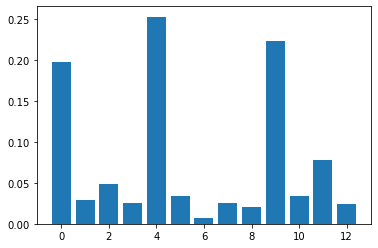

confusion matrix DecisionTreeClassifier(max_features=13)
[[717  25]
 [ 21  71]]
classification report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       742
           1       0.74      0.77      0.76        92

    accuracy                           0.94       834
   macro avg       0.86      0.87      0.86       834
weighted avg       0.95      0.94      0.95       834

accuracy score
0.9448441247002398
Feature: 0,	 Name: melspectrogram_max_6dB, 	 Score: 19.20165
Feature: 1,	 Name: melspectrogram_corr_6dB, 	 Score: 2.76717
Feature: 2,	 Name: melspectrogram_std_6dB, 	 Score: 6.24954
Feature: 3,	 Name: mfcc_6dB, 	 Score: 2.79403
Feature: 4,	 Name: max perc_6dB, 	 Score: 24.28168
Feature: 5,	 Name: min perc_6dB, 	 Score: 2.53132
Feature: 6,	 Name: melspectrogram_max_0dB, 	 Score: 1.14158
Feature: 7,	 Name: melspectrogram_corr_0dB, 	 Score: 1.89704
Feature: 8,	 Name: rms_0dB, 	 Score: 1.61650
Feature: 9,	 Name: max perc_0dB, 	 Score: 

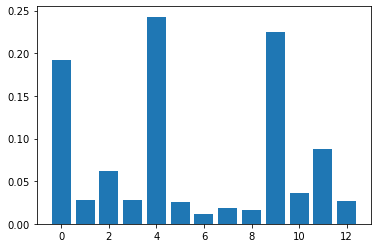

confusion matrix DecisionTreeClassifier(max_features='auto')
[[718  24]
 [ 17  75]]
classification report
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       742
           1       0.76      0.82      0.79        92

    accuracy                           0.95       834
   macro avg       0.87      0.89      0.88       834
weighted avg       0.95      0.95      0.95       834

accuracy score
0.9508393285371702
Feature: 0,	 Name: melspectrogram_max_6dB, 	 Score: 16.61828
Feature: 1,	 Name: melspectrogram_corr_6dB, 	 Score: 2.51994
Feature: 2,	 Name: melspectrogram_std_6dB, 	 Score: 2.37140
Feature: 3,	 Name: mfcc_6dB, 	 Score: 2.82691
Feature: 4,	 Name: max perc_6dB, 	 Score: 3.76950
Feature: 5,	 Name: min perc_6dB, 	 Score: 4.20426
Feature: 6,	 Name: melspectrogram_max_0dB, 	 Score: 5.80669
Feature: 7,	 Name: melspectrogram_corr_0dB, 	 Score: 5.25155
Feature: 8,	 Name: rms_0dB, 	 Score: 1.66009
Feature: 9,	 Name: max perc_0dB, 	 Scor

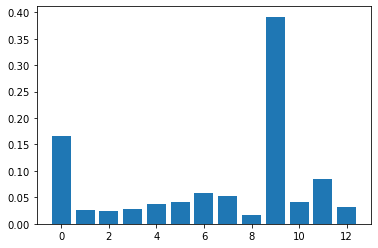

confusion matrix DecisionTreeClassifier(max_features='sqrt')
[[711  31]
 [ 25  67]]
classification report
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       742
           1       0.68      0.73      0.71        92

    accuracy                           0.93       834
   macro avg       0.82      0.84      0.83       834
weighted avg       0.93      0.93      0.93       834

accuracy score
0.9328537170263789
Feature: 0,	 Name: melspectrogram_max_6dB, 	 Score: 10.73241
Feature: 1,	 Name: melspectrogram_corr_6dB, 	 Score: 20.17086
Feature: 2,	 Name: melspectrogram_std_6dB, 	 Score: 6.43419
Feature: 3,	 Name: mfcc_6dB, 	 Score: 2.07209
Feature: 4,	 Name: max perc_6dB, 	 Score: 16.39781
Feature: 5,	 Name: min perc_6dB, 	 Score: 3.91365
Feature: 6,	 Name: melspectrogram_max_0dB, 	 Score: 2.40450
Feature: 7,	 Name: melspectrogram_corr_0dB, 	 Score: 3.44387
Feature: 8,	 Name: rms_0dB, 	 Score: 2.52866
Feature: 9,	 Name: max perc_0dB, 	 Sc

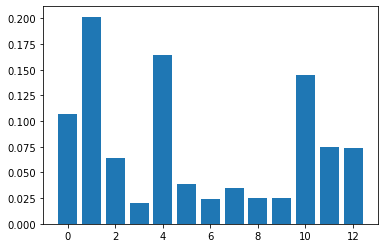

confusion matrix DecisionTreeClassifier(max_features='log2')
[[721  21]
 [ 19  73]]
classification report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       742
           1       0.78      0.79      0.78        92

    accuracy                           0.95       834
   macro avg       0.88      0.88      0.88       834
weighted avg       0.95      0.95      0.95       834

accuracy score
0.9520383693045563
Feature: 0,	 Name: melspectrogram_max_6dB, 	 Score: 12.20154
Feature: 1,	 Name: melspectrogram_corr_6dB, 	 Score: 6.29749
Feature: 2,	 Name: melspectrogram_std_6dB, 	 Score: 3.94020
Feature: 3,	 Name: mfcc_6dB, 	 Score: 2.82381
Feature: 4,	 Name: max perc_6dB, 	 Score: 25.97371
Feature: 5,	 Name: min perc_6dB, 	 Score: 20.72331
Feature: 6,	 Name: melspectrogram_max_0dB, 	 Score: 6.22564
Feature: 7,	 Name: melspectrogram_corr_0dB, 	 Score: 3.88299
Feature: 8,	 Name: rms_0dB, 	 Score: 2.91224
Feature: 9,	 Name: max perc_0dB, 	 Sc

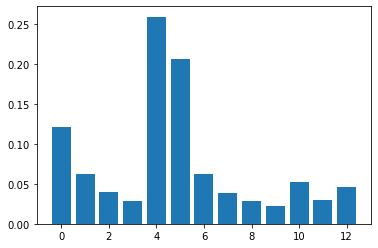

confusion matrix RandomForestClassifier()
[[736   6]
 [ 22  70]]
classification report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       742
           1       0.92      0.76      0.83        92

    accuracy                           0.97       834
   macro avg       0.95      0.88      0.91       834
weighted avg       0.97      0.97      0.97       834

accuracy score
0.9664268585131894
Feature: 0,	 Name: melspectrogram_max_6dB, 	 Score: 11.34051
Feature: 1,	 Name: melspectrogram_corr_6dB, 	 Score: 6.67074
Feature: 2,	 Name: melspectrogram_std_6dB, 	 Score: 5.09367
Feature: 3,	 Name: mfcc_6dB, 	 Score: 2.96017
Feature: 4,	 Name: max perc_6dB, 	 Score: 15.73509
Feature: 5,	 Name: min perc_6dB, 	 Score: 7.66053
Feature: 6,	 Name: melspectrogram_max_0dB, 	 Score: 3.48124
Feature: 7,	 Name: melspectrogram_corr_0dB, 	 Score: 6.63302
Feature: 8,	 Name: rms_0dB, 	 Score: 3.03800
Feature: 9,	 Name: max perc_0dB, 	 Score: 15.04101
Featur

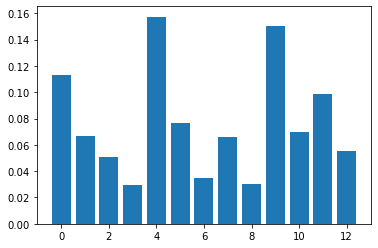

confusion matrix GradientBoostingClassifier()
[[736   6]
 [ 24  68]]
classification report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       742
           1       0.92      0.74      0.82        92

    accuracy                           0.96       834
   macro avg       0.94      0.87      0.90       834
weighted avg       0.96      0.96      0.96       834

accuracy score
0.9640287769784173
Feature: 0,	 Name: melspectrogram_max_6dB, 	 Score: 23.72424
Feature: 1,	 Name: melspectrogram_corr_6dB, 	 Score: 3.14120
Feature: 2,	 Name: melspectrogram_std_6dB, 	 Score: 2.71339
Feature: 3,	 Name: mfcc_6dB, 	 Score: 0.97862
Feature: 4,	 Name: max perc_6dB, 	 Score: 25.19263
Feature: 5,	 Name: min perc_6dB, 	 Score: 3.59641
Feature: 6,	 Name: melspectrogram_max_0dB, 	 Score: 1.06344
Feature: 7,	 Name: melspectrogram_corr_0dB, 	 Score: 5.86023
Feature: 8,	 Name: rms_0dB, 	 Score: 1.68918
Feature: 9,	 Name: max perc_0dB, 	 Score: 19.68931
Fe

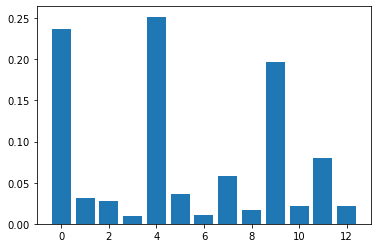

array([0.95958084, 0.95052474, 0.96101949, 0.95952024, 0.94902549])

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = []
clfs = []

clfs.append(DecisionTreeClassifier(max_depth=35))
clfs.append(DecisionTreeClassifier(max_features = 13))
clfs.append(DecisionTreeClassifier(max_features = "auto"))
clfs.append(DecisionTreeClassifier(max_features = "sqrt"))
clfs.append(DecisionTreeClassifier(max_features = "log2"))

clfs.append(RandomForestClassifier())

clfs.append(GradientBoostingClassifier())
for classifier in clfs:
    classifier.fit(X_train, y_train)
    y_pred= classifier.predict(X_test)
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    print('confusion matrix', classifier)
    print(confusion_matrix(y_test, y_pred))
    print('classification report')
    print(classification_report(y_test, y_pred))
    print('accuracy score')
    print(accuracy_score(y_test, y_pred))
    
    x_columns=list(X_train.columns)
    
    # get importance
    unimportant_columns =[]

    importance = classifier.feature_importances_
    # summarize feature importance
    for i,v in enumerate(importance):
        print(f'Feature: %0d,\t Name: {x_columns[i]}, \t Score: %.5f' % (i,v*100))
    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

scores = cross_val_score(pipeline, X_train, y_train, cv=5)
scores
         
    

array([[<AxesSubplot:xlabel='melspectrogram_max_6dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='melspectrogram_corr_6dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='melspectrogram_std_6dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='mfcc_6dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='max perc_6dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='min perc_6dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='melspectrogram_max_0dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='melspectrogram_corr_0dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='rms_0dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='max perc_0dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='min perc_0dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='max perc_-6dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot

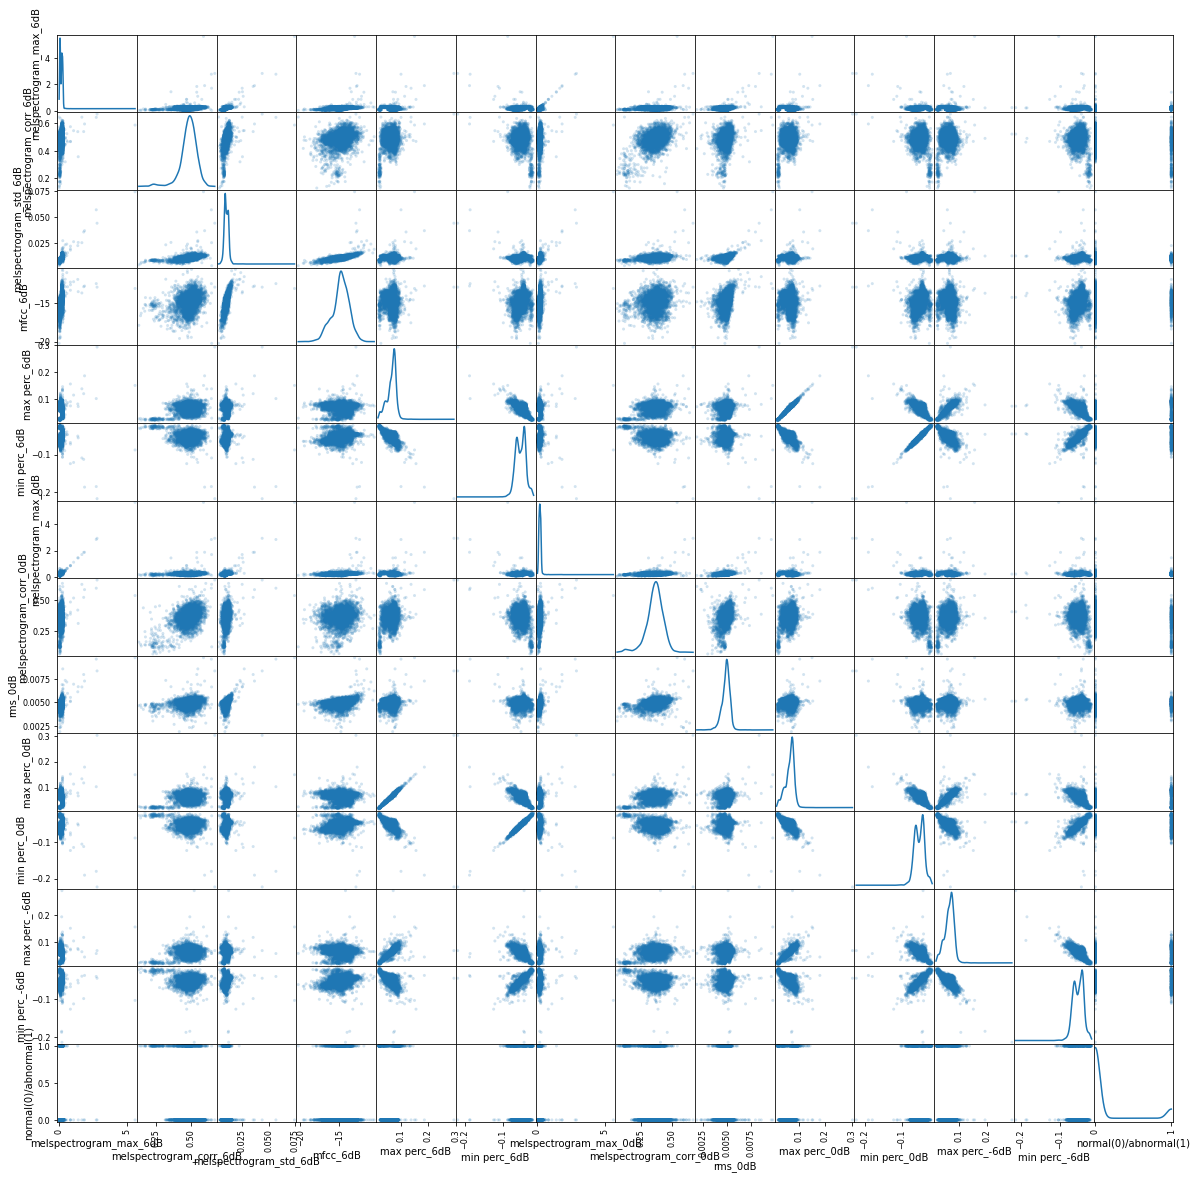

In [11]:
pd.plotting.scatter_matrix(valve_reduced, alpha=0.2, figsize=(20,20), diagonal='kde')

In [12]:
valve_reduced.corr().style.background_gradient(cmap="coolwarm")

,melspectrogram_max_6dB,melspectrogram_corr_6dB,melspectrogram_std_6dB,mfcc_6dB,max perc_6dB,min perc_6dB,melspectrogram_max_0dB,melspectrogram_corr_0dB,rms_0dB,max perc_0dB,min perc_0dB,max perc_-6dB,min perc_-6dB,normal(0)/abnormal(1)
melspectrogram_max_6dB,1.000000,0.247059,0.817646,0.378502,-0.026214,0.077078,0.909349,0.174483,0.431514,-0.040419,0.078320,-0.157587,0.220745,0.021206
melspectrogram_corr_6dB,0.247059,1.000000,0.445966,0.277829,0.291761,-0.152168,0.166343,0.507056,0.258217,0.271814,-0.144253,0.219000,-0.088098,-0.311362
melspectrogram_std_6dB,0.817646,0.445966,1.000000,0.665713,0.124396,0.093924,0.716202,0.277971,0.539258,0.094541,0.101558,-0.023567,0.232544,-0.028917
mfcc_6dB,0.378502,0.277829,0.665713,1.000000,-0.058289,0.255880,0.252016,0.167892,0.326076,-0.086119,0.268422,-0.132450,0.289827,-0.013000
max perc_6dB,-0.026214,0.291761,0.124396,-0.058289,1.000000,-0.689623,0.031900,0.330952,0.120970,0.985867,-0.690580,0.835002,-0.562539,-0.061303
min perc_6dB,0.077078,-0.152168,0.093924,0.255880,-0.689623,1.000000,-0.043212,-0.233626,0.011397,-0.713537,0.981933,-0.622584,0.783120,0.033053
melspectrogram_max_0dB,0.909349,0.166343,0.716202,0.252016,0.031900,-0.043212,1.000000,0.217026,0.441648,0.028053,-0.044309,-0.084643,0.110033,0.005269
melspectrogram_corr_0dB,0.174483,0.507056,0.277971,0.167892,0.330952,-0.233626,0.217026,1.000000,0.288796,0.352904,-0.251925,0.288710,-0.178949,-0.267929
rms_0dB,0.431514,0.258217,0.539258,0.326076,0.120970,0.011397,0.441648,0.288796,1.000000,0.120026,-0.004919,0.037987,0.087625,-0.046125
max perc_0dB,-0.040419,0.271814,0.094541,-0.086119,0.985867,-0.713537,0.028053,0.352904,0.120026,1.000000,-0.714206,0.837105,-0.585859,-0.065643


In [13]:
# Dataframe based on score of the features

valve_reduced2 = valve_reduced[['melspectrogram_max_6dB',
                       'melspectrogram_corr_6dB',
                       'mfcc_6dB',
                      'max perc_6dB',
                      'min perc_6dB',
                       'melspectrogram_corr_0dB',
                      'rms_0dB',
                      'normal(0)/abnormal(1)']]
valve_reduced2.columns

Index(['melspectrogram_max_6dB', 'melspectrogram_corr_6dB', 'mfcc_6dB',
       'max perc_6dB', 'min perc_6dB', 'melspectrogram_corr_0dB', 'rms_0dB',
       'normal(0)/abnormal(1)'],
      dtype='object')

In [14]:
#Seperate train and test data
X_train, X_test, y_train, y_test = train_test_split(valve_reduced2.drop(columns=['normal(0)/abnormal(1)'], axis=1),
                                                   valve_reduced2['normal(0)/abnormal(1)'],
                                                   test_size = 0.2,
                                                   random_state = 10)

In [15]:
pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
pipeline.steps

[('scaler', StandardScaler()), ('svc', SVC())]

confusion matrix DecisionTreeClassifier(max_depth=35)
[[705  37]
 [ 24  68]]
classification report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       742
           1       0.65      0.74      0.69        92

    accuracy                           0.93       834
   macro avg       0.81      0.84      0.82       834
weighted avg       0.93      0.93      0.93       834

accuracy score
0.9268585131894485
Feature: 0,	 Name: melspectrogram_max_6dB, 	 Score: 15.79921
Feature: 1,	 Name: melspectrogram_corr_6dB, 	 Score: 5.26548
Feature: 2,	 Name: mfcc_6dB, 	 Score: 8.06800
Feature: 3,	 Name: max perc_6dB, 	 Score: 52.16725
Feature: 4,	 Name: min perc_6dB, 	 Score: 7.70775
Feature: 5,	 Name: melspectrogram_corr_0dB, 	 Score: 6.46822
Feature: 6,	 Name: rms_0dB, 	 Score: 4.52408


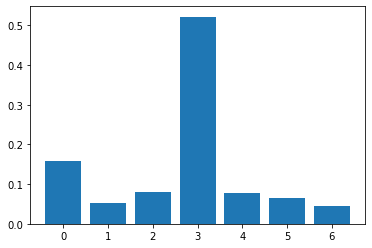

confusion matrix DecisionTreeClassifier(max_features=7)
[[705  37]
 [ 25  67]]
classification report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       742
           1       0.64      0.73      0.68        92

    accuracy                           0.93       834
   macro avg       0.80      0.84      0.82       834
weighted avg       0.93      0.93      0.93       834

accuracy score
0.9256594724220624
Feature: 0,	 Name: melspectrogram_max_6dB, 	 Score: 13.36433
Feature: 1,	 Name: melspectrogram_corr_6dB, 	 Score: 6.33644
Feature: 2,	 Name: mfcc_6dB, 	 Score: 6.99798
Feature: 3,	 Name: max perc_6dB, 	 Score: 52.53356
Feature: 4,	 Name: min perc_6dB, 	 Score: 7.49001
Feature: 5,	 Name: melspectrogram_corr_0dB, 	 Score: 8.13826
Feature: 6,	 Name: rms_0dB, 	 Score: 5.13943


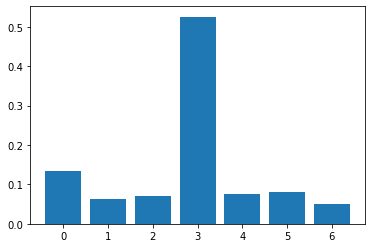

confusion matrix DecisionTreeClassifier(max_features='auto')
[[703  39]
 [ 27  65]]
classification report
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       742
           1       0.62      0.71      0.66        92

    accuracy                           0.92       834
   macro avg       0.79      0.83      0.81       834
weighted avg       0.93      0.92      0.92       834

accuracy score
0.920863309352518
Feature: 0,	 Name: melspectrogram_max_6dB, 	 Score: 17.67921
Feature: 1,	 Name: melspectrogram_corr_6dB, 	 Score: 5.82386
Feature: 2,	 Name: mfcc_6dB, 	 Score: 8.50644
Feature: 3,	 Name: max perc_6dB, 	 Score: 32.02405
Feature: 4,	 Name: min perc_6dB, 	 Score: 21.86852
Feature: 5,	 Name: melspectrogram_corr_0dB, 	 Score: 6.07474
Feature: 6,	 Name: rms_0dB, 	 Score: 8.02318


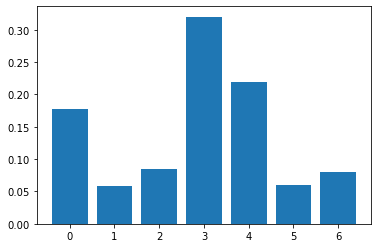

confusion matrix DecisionTreeClassifier(max_features='sqrt')
[[711  31]
 [ 25  67]]
classification report
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       742
           1       0.68      0.73      0.71        92

    accuracy                           0.93       834
   macro avg       0.82      0.84      0.83       834
weighted avg       0.93      0.93      0.93       834

accuracy score
0.9328537170263789
Feature: 0,	 Name: melspectrogram_max_6dB, 	 Score: 14.30212
Feature: 1,	 Name: melspectrogram_corr_6dB, 	 Score: 23.89064
Feature: 2,	 Name: mfcc_6dB, 	 Score: 4.52934
Feature: 3,	 Name: max perc_6dB, 	 Score: 36.80574
Feature: 4,	 Name: min perc_6dB, 	 Score: 6.69314
Feature: 5,	 Name: melspectrogram_corr_0dB, 	 Score: 6.19348
Feature: 6,	 Name: rms_0dB, 	 Score: 7.58554


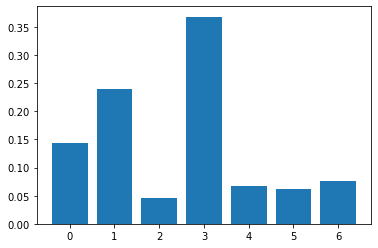

confusion matrix DecisionTreeClassifier(max_features='log2')
[[715  27]
 [ 26  66]]
classification report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       742
           1       0.71      0.72      0.71        92

    accuracy                           0.94       834
   macro avg       0.84      0.84      0.84       834
weighted avg       0.94      0.94      0.94       834

accuracy score
0.9364508393285371
Feature: 0,	 Name: melspectrogram_max_6dB, 	 Score: 16.12349
Feature: 1,	 Name: melspectrogram_corr_6dB, 	 Score: 7.87362
Feature: 2,	 Name: mfcc_6dB, 	 Score: 7.58997
Feature: 3,	 Name: max perc_6dB, 	 Score: 39.81402
Feature: 4,	 Name: min perc_6dB, 	 Score: 15.00359
Feature: 5,	 Name: melspectrogram_corr_0dB, 	 Score: 8.12355
Feature: 6,	 Name: rms_0dB, 	 Score: 5.47176


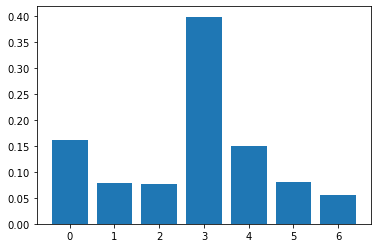

confusion matrix RandomForestClassifier()
[[737   5]
 [ 28  64]]
classification report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       742
           1       0.93      0.70      0.80        92

    accuracy                           0.96       834
   macro avg       0.95      0.84      0.89       834
weighted avg       0.96      0.96      0.96       834

accuracy score
0.960431654676259
Feature: 0,	 Name: melspectrogram_max_6dB, 	 Score: 15.40246
Feature: 1,	 Name: melspectrogram_corr_6dB, 	 Score: 12.27665
Feature: 2,	 Name: mfcc_6dB, 	 Score: 6.23394
Feature: 3,	 Name: max perc_6dB, 	 Score: 31.24340
Feature: 4,	 Name: min perc_6dB, 	 Score: 16.48101
Feature: 5,	 Name: melspectrogram_corr_0dB, 	 Score: 12.37006
Feature: 6,	 Name: rms_0dB, 	 Score: 5.99249


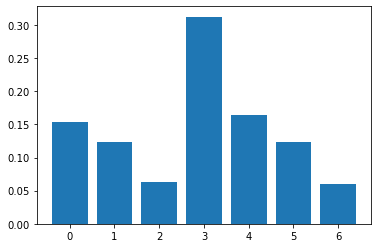

confusion matrix GradientBoostingClassifier()
[[738   4]
 [ 26  66]]
classification report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       742
           1       0.94      0.72      0.81        92

    accuracy                           0.96       834
   macro avg       0.95      0.86      0.90       834
weighted avg       0.96      0.96      0.96       834

accuracy score
0.9640287769784173
Feature: 0,	 Name: melspectrogram_max_6dB, 	 Score: 28.02144
Feature: 1,	 Name: melspectrogram_corr_6dB, 	 Score: 4.47058
Feature: 2,	 Name: mfcc_6dB, 	 Score: 2.30669
Feature: 3,	 Name: max perc_6dB, 	 Score: 46.04385
Feature: 4,	 Name: min perc_6dB, 	 Score: 6.27111
Feature: 5,	 Name: melspectrogram_corr_0dB, 	 Score: 8.96437
Feature: 6,	 Name: rms_0dB, 	 Score: 3.92196


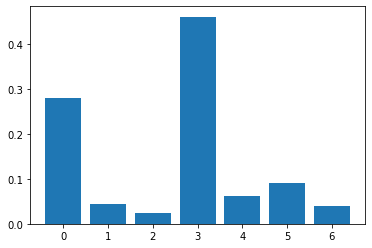

array([0.94760479, 0.94152924, 0.94902549, 0.95352324, 0.94002999])

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = []
clfs = []

clfs.append(DecisionTreeClassifier(max_depth=35))
clfs.append(DecisionTreeClassifier(max_features = 7))
clfs.append(DecisionTreeClassifier(max_features = "auto"))
clfs.append(DecisionTreeClassifier(max_features = "sqrt"))
clfs.append(DecisionTreeClassifier(max_features = "log2"))

clfs.append(RandomForestClassifier())

clfs.append(GradientBoostingClassifier())
for classifier in clfs:
    classifier.fit(X_train, y_train)
    y_pred= classifier.predict(X_test)
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    print('confusion matrix', classifier)
    print(confusion_matrix(y_test, y_pred))
    print('classification report')
    print(classification_report(y_test, y_pred))
    print('accuracy score')
    print(accuracy_score(y_test, y_pred))
    
    x_columns=list(X_train.columns)
    
    # get importance
    unimportant_columns =[]

    importance = classifier.feature_importances_
    # summarize feature importance
    for i,v in enumerate(importance):
        print(f'Feature: %0d,\t Name: {x_columns[i]}, \t Score: %.5f' % (i,v*100))
    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

scores = cross_val_score(pipeline, X_train, y_train, cv=5)
scores
         
    

array([[<AxesSubplot:xlabel='melspectrogram_max_6dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='melspectrogram_corr_6dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='mfcc_6dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='max perc_6dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='min perc_6dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='melspectrogram_corr_0dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='rms_0dB', ylabel='melspectrogram_max_6dB'>,
        <AxesSubplot:xlabel='normal(0)/abnormal(1)', ylabel='melspectrogram_max_6dB'>],
       [<AxesSubplot:xlabel='melspectrogram_max_6dB', ylabel='melspectrogram_corr_6dB'>,
        <AxesSubplot:xlabel='melspectrogram_corr_6dB', ylabel='melspectrogram_corr_6dB'>,
        <AxesSubplot:xlabel='mfcc_6dB', ylabel='melspectrogram_corr_6dB'>,
        <AxesSubplot:xlabel='max perc_6dB', ylabel='melspectrogram_corr_6dB'>,
        <A

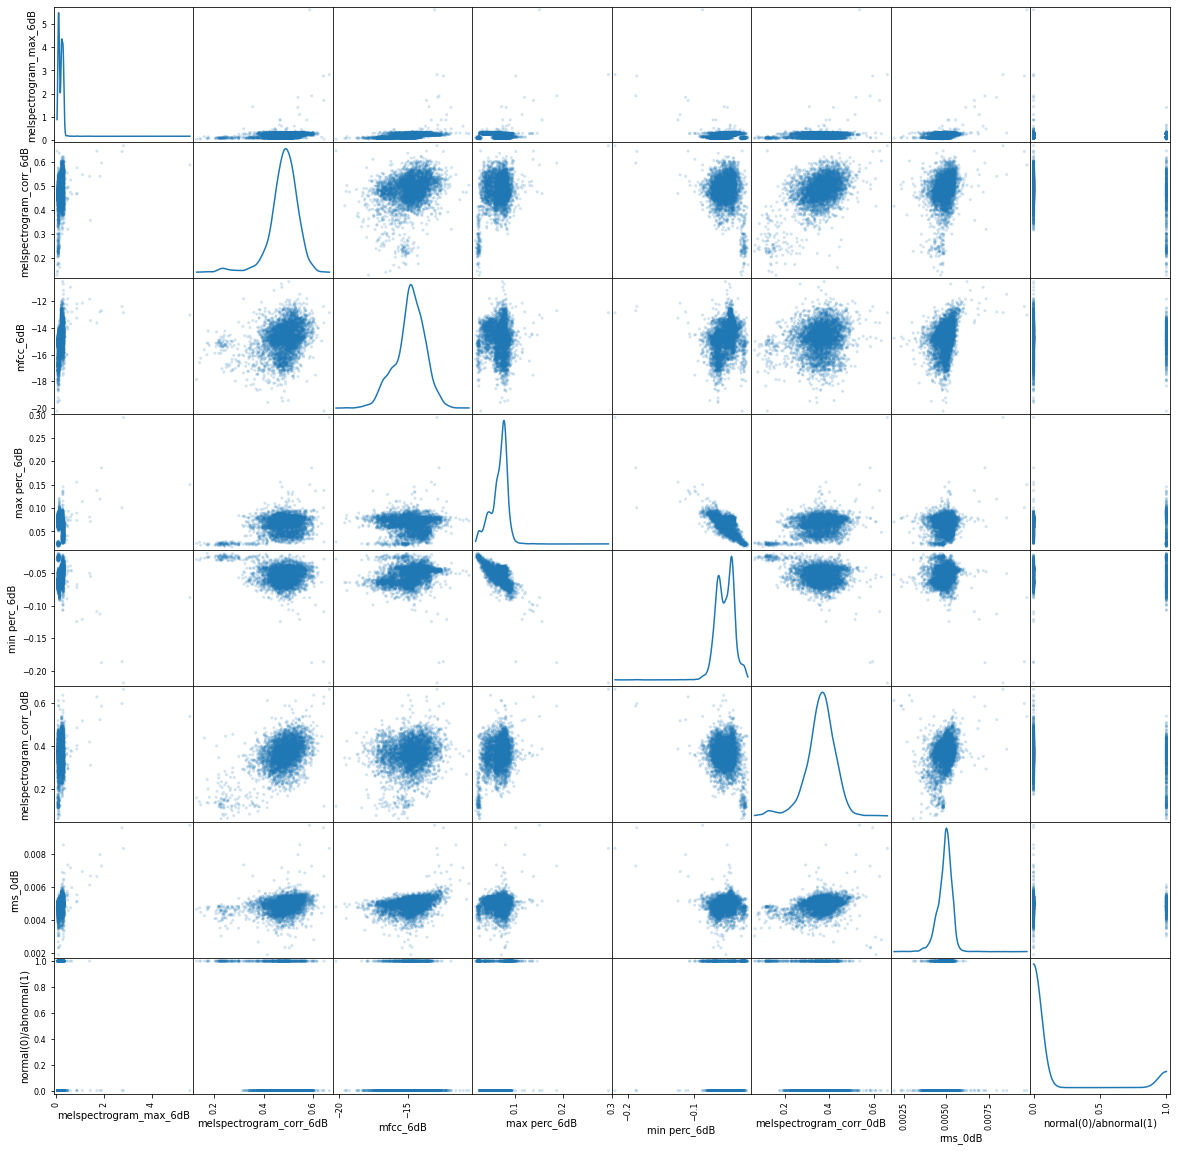

In [17]:
pd.plotting.scatter_matrix(valve_reduced2, alpha=0.2, figsize=(20,20), diagonal='kde')

In [18]:
valve_reduced2.corr().style.background_gradient(cmap="coolwarm")

,melspectrogram_max_6dB,melspectrogram_corr_6dB,mfcc_6dB,max perc_6dB,min perc_6dB,melspectrogram_corr_0dB,rms_0dB,normal(0)/abnormal(1)
melspectrogram_max_6dB,1.000000,0.247059,0.378502,-0.026214,0.077078,0.174483,0.431514,0.021206
melspectrogram_corr_6dB,0.247059,1.000000,0.277829,0.291761,-0.152168,0.507056,0.258217,-0.311362
mfcc_6dB,0.378502,0.277829,1.000000,-0.058289,0.255880,0.167892,0.326076,-0.013000
max perc_6dB,-0.026214,0.291761,-0.058289,1.000000,-0.689623,0.330952,0.120970,-0.061303
min perc_6dB,0.077078,-0.152168,0.255880,-0.689623,1.000000,-0.233626,0.011397,0.033053
melspectrogram_corr_0dB,0.174483,0.507056,0.167892,0.330952,-0.233626,1.000000,0.288796,-0.267929
rms_0dB,0.431514,0.258217,0.326076,0.120970,0.011397,0.288796,1.000000,-0.046125
normal(0)/abnormal(1),0.021206,-0.311362,-0.013000,-0.061303,0.033053,-0.267929,-0.046125,1.000000


## Questions for the client

The dataset was collected using TAMAGO-03 microphone, manu-factured by System In Frontier Inc [21]. It is a circular microphonearray which consists of eight distinct microphones; the details ofthe microphone array are shown in Figure 1. By using the mi-crophone array, not only single-channel-based approaches but alsomulti-channel-based ones can be evaluated. The microphone arraywas kept at a distance of 50 cm from the machine (10 cm in caseof valves); 10-second sound segments were recorded. The datasetcontains eight separate channels for each segment. Figure 2 depictsthe recording setup with the direction and distance for each kind ofmachine. It should be noted that each machine sound was recordedin separate session. In running condition, the sound of the machinewas recorded as 16-bit audio signals sampled at 16 kHz in a rever-berant environment. Apart from the target machine sound, back-ground noise in multiple real factories was continuously recorded to mix it with the target machine sound for simulating real envi-ronments. For recording the background noise, we used the samemicrophone array as for the target machine sound.

The MIMII dataset contains the sound of four different types of ma-chines: valves, pumps, fans, and slide rails. The valves are solenoidvalves that are repeatedly opened and closed. The pumps are waterpumps, which drained water from a pool and discharged water tothe pool continuously. The fans represent industrial fans, which areused to provide a continuous ﬂow or gas of air in factories. Theslide rails in this paper represent linear slide systems, which consistof a moving platform and a stage base. The types of the sounds pro-duced by the machines are stationary and non-stationary, have dif-ferent features, and different degrees of difﬁculty. Figure 3 depictsa power spectrogram of the sound of all four types of machines,clearly showing that each machine has its unique sound character-istics. Individual machines may be of a different product model

For each machine type and model ID, all the segments weresplit into a training dataset and a test dataset. All the anomaloussegments were regarded as the test dataset, the same number ofnormal segments were randomly selected and regarded as the testdataset, and all the rest normal segments were regarded as the train-ing dataset. By using the training dataset consisting only of normalones, different autoencoders were trained for each machine type andmodel ID. Anomaly detection was performed for each segment bythresholding the reconstruction error averaged over 10 seconds, andthe area under the curve (AUC) values were calculated for the testdataset for each machine type and model ID. In addition to this, wealso considered different levels of SNR (with factory noise) in theexperiment, for example, 6 dB, 0 dB, and -6 dB.Table 3 shows the AUCs averaged over three training runs withindependent initializations. In Table 3, It is clear that the AUCs forvalves are lower than the other machines. Sound signals of valvesare non-stationary, in particular, impulsive and sparse in time, andthe reconstruction error averaged over time tends to be small. So,it is difﬁcult to detect anomalies for valves. In contrast, it is easierto detect anomalies for fans than the other machines because soundsignals of fans are stationary. Moreover, for some machine models,the AUC decreases rapidly as the noise level increases. These re-sults indicate that it is important to solve the degradation caused bynon-stationarity and noise for unsupervised anomalous sound de-tection

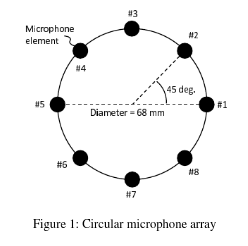

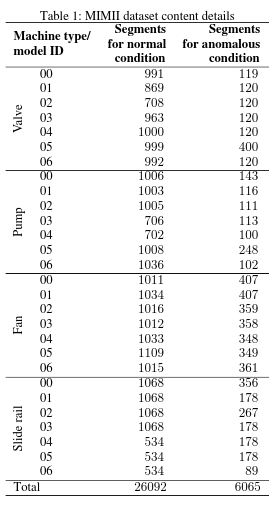

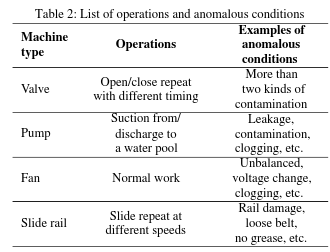

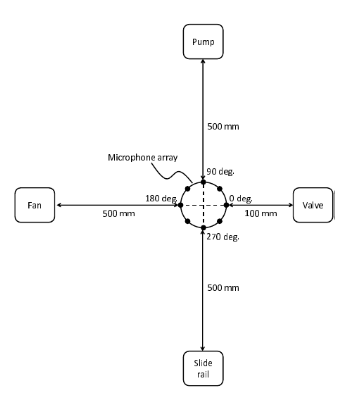

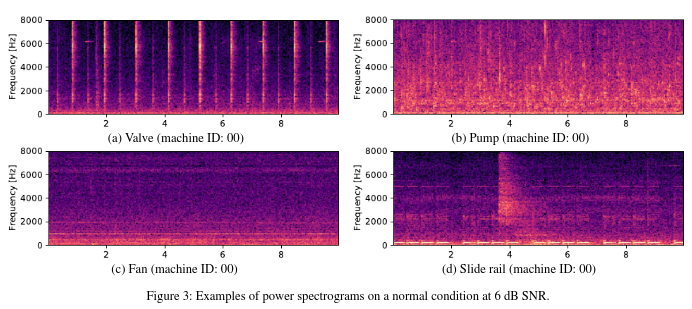

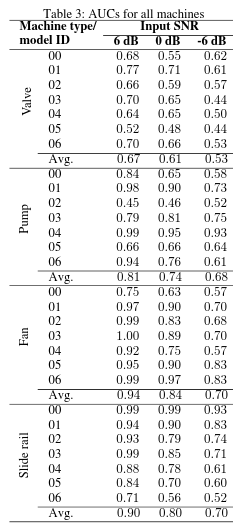

- more audio files available?
- will it be used on other machines than the ones we got?
- is the goal to be able to detect all the abnormal operations?
- is the goal to be able to determine which type of machine we hear? 
- should we able to distinguish the modeltype of a machine?
- are you going to use same equipment for measuring?
- should we be able to detect the type of abnormal operations?